# The demonstration of the tropical rainfall diagnostic for high-resolution data

### Content


1. [The load of packages, modules, and data](#1-load-of-packages-modules-and-data)

2. [Calculation of histograms]()

3. [Comparison of histograms](#2-comparison-of-histograms)

[Go to the end of file](#the-end)

We split the function to calculate the histogram and the demonstration because the initial function to calculate the histogram has a big memory overhead, and this overhead is significant for high-resolution data. 

The histogram calculations for low-resolution data have more features. Namely, the description of the functionality is following:

|  | Low-resolution | High-resolution |
| --- | --- | --- |
| name of function | histogram_lowres   | histogram|
| uniform binning | + | + |
| non-uniform (log-spaced) binning | + | - |
| lazy (or delayed) mode | + | - |
|  weights (weights=reader.grid_area) | + | - |

In the following deliverable of the diagnostic, we will provide the unique function for data with any grid that wil contain all necessary features for high-resolution data (like non-uniform binning).

#

## 1. The load of packages, modules, and data

In [1]:
import sys
from aqua import Reader
sys.path.insert(0, '../../')
from tropical_rainfall import Tropical_Rainfall

In [2]:
from aqua.slurm import slurm

##### Initialization of the diagnostic

In [11]:
# Please change the path to the NetCDF files and the PDF files to your own path

path_to_netcdf = "/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/"
path_to_pdf    = "/work/bb1153/b382267/tropical_rainfall_cicle3/PDF/"

In [ ]:
slurm.job(cores=16, memory="250 GB")

#### ICON, ngc3028, lra

##### For big datasets, it is better to calculate and store the histograms by months instead of the full-time range of the dataset. 

The main reasons for that are the following:
- The user can easily keep track of precipitation from a specific season. 
- To keep calculations safe from Runtime errors and memory issues. 

In the current stage of tropical-rainfall diagnostics, we use a streaming-aqua mode in order to split the input data over months. 

#### IFS, tco1279-orca025-cycle3

The bottleneck in the histogram calculation is the necessity to regrid the data and modify the frequency of the original data. 

In [3]:
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 1000, first_edge = 0, width_of_bin = 1, loglevel='debug')

In [18]:
reader              = Reader(model="IFS", exp="tco1279-orca025-cycle3", source="2D_1h_native", regrid="r010")
ifs_tco1279_orca025_retrived = reader.retrieve()

for year in range(2020, 2026):
    for x in range(1, 12, 2):
        ifs_tco1279_orca025 = ifs_tco1279_orca025_retrived.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        ifs_tco1279_orca025 = reader.timmean(ifs_tco1279_orca025, freq="3H")
        ifs_tco1279_orca025 = reader.regrid(ifs_tco1279_orca025)
        diag.histogram(ifs_tco1279_orca025, path_to_histogram=path_to_netcdf, threshold = 30, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

#### IFS, tco2559_ng5

In [ ]:
reader                      = Reader(model="IFS", exp="tco2559-ng5-cycle3", source="2D_1h_native",  regrid="r010")
data_ifs_tco2559_ng5_ret    = reader.retrieve()

path_to_netcdf = '/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco2559-ng5-cycle3/'
for year in range(2020, 2026):
    for x in range(1, 12, 2):
        data_ifs_tco2559_ng5 = data_ifs_tco2559_ng5_ret.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        data_ifs_tco2559_ng5 = reader.timmean(data_ifs_tco2559_ng5, freq="3H")
        data_ifs_tco2559_ng5 = reader.regrid(data_ifs_tco2559_ng5)
        data_ifs_tco2559_ng5  = data_ifs_tco2559_ng5['tprate'][:]*86400
        diag.histogram(data_ifs_tco2559_ng5, path_to_histogram=path_to_netcdf, threshold = 10, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

#### ICON

In [ ]:
reader = Reader(model="ICON", exp="ngc3028", source="PT3H", zoom=10,  regrid="r010")
data_icon3028_retrieved = reader.retrieve()

path_to_netcdf ="/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/PT3H/"

for year in range(2020, 2026):
    for x in range(1, 12, 2):
        data_icon3028 = data_icon3028_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        data_icon3028 = data_icon3028['tprate'][:]*86400
        data_icon3028 = reader.regrid(data_icon3028)
        diag.histogram(data_icon3028, path_to_histogram=path_to_netcdf, 
                     name_of_file="icon3028_tco1279_PT3H_r010_3h")

#### MSWEP 

In [ ]:
reader              = Reader(model="MSWEP", exp="past", source="3hourly")
mswep_retrieved     = reader.retrieve()
path_to_netcdf      ="/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_no_fix/"


for year in range(1979, 2020):
    for x in range(1, 12, 2):
        
        mswep  = mswep_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        mswep   = mswep['tprate'][:]*86400
        mswep.attrs['units'] = "mm/day"
        diag.histogram(mswep, path_to_histogram=path_to_netcdf, 
                     name_of_file="trop_rainfall_mswep_past_3hourly_r010")

## 2. Comparison of histograms

In [6]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco2559-ng5-cycle3/'
hist_ifs_2559 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs,  all = True)

2023-07-19 02:39:07 :: Trop. Rainfall :: INFO     -> Histograms are merged.


In [7]:
path_to_ifs_orca='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco1279-orca025-cycle3/'
hist_ifs_tco1279 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs_orca, all = True)

2023-07-19 02:39:31 :: Trop. Rainfall :: INFO     -> Histograms are merged.


In [9]:
path_to_icon='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/PT3H/'
hist_icon_ngc3028 = diag.merge_list_of_histograms(path_to_histograms = path_to_icon,   all = True)

2023-07-19 02:43:27 :: Trop. Rainfall :: INFO     -> Histograms are merged.


In [8]:
path_to_mswep='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_no_fix/'
hist_mswep = diag.merge_list_of_histograms(path_to_histograms = path_to_mswep,  all = True)

2023-07-19 02:43:06 :: Trop. Rainfall :: INFO     -> Histograms are merged.


2023-07-19 02:56:48 :: create_folder :: WARNING  -> Folder /work/bb1153/b382267/tropical_rainfall_cicle3/PDF/ already exists


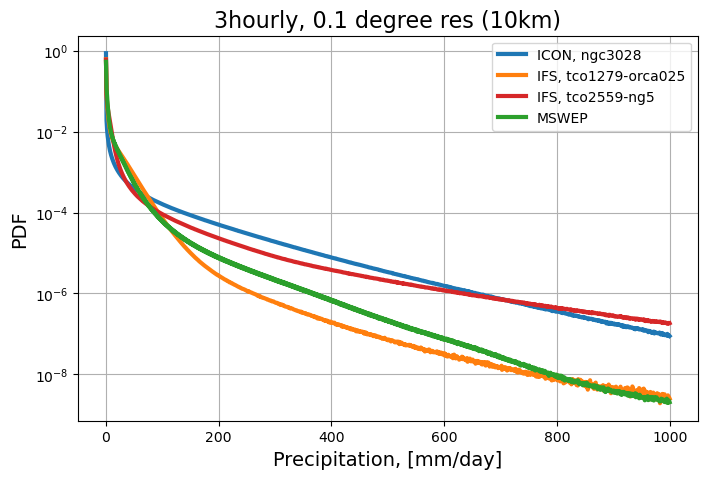

In [12]:
add = diag.histogram_plot(hist_icon_ngc3028,   pdf=True,   figsize=1,                         
                legend='ICON, ngc3028')
add = diag.histogram_plot(hist_ifs_tco1279.pdf,    pdf=False, frequency=False,   add = add,  color ='tab:orange', 
                legend='IFS, tco1279-orca025') 
add = diag.histogram_plot(hist_ifs_2559,       pdf=True,   add = add,  color ='tab:red', 
                legend='IFS, tco2559-ng5') 
add = diag.histogram_plot(hist_mswep,          pdf=True,   add = add,  color ='tab:green', 
                legend='MSWEP', 
                plot_title='3hourly, 0.1 degree res (10km)', loc='upper right',
                path_to_pdf=path_to_pdf, 
                pdf_format=False,  
                name_of_file='icon_ngc3028_ifs_tco2559_ng5_ifs_tco1279_orca025_mswep_10km_3h')

#

## Check how the diversity of histograms changes with time. 

##### The end